# Orders Forecasting Challenge

## References

## Import Python Libraries

In [1423]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import boxcox, boxcox_normplot, zscore, median_test, median_abs_deviation
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
import requests
import datetime as dt

# Import Notebook Functions

In [1424]:
# get regression metric functions from stored python file
filepath = "https://raw.githubusercontent.com/notfakearcher/julian/main/01_practice/machine_learning/supervised_learning/regression/regression_metrics.py"
request = requests.get(filepath)
with open("regression_metrics.py", "wb") as f:
  f.write(request.content)
from regression_metrics import jra_regression_metrics

## Global Variables

In [1425]:
# random state seed for repeatability
random_state = 4781

# colors
c1 = 'grey'
c2 = 'red'
c3 = 'blue'

# root folder
root_folder = 'https://raw.githubusercontent.com/notfakearcher/julian/main/04_projects/orders_forecasting/'

# data folder
data_folder = root_folder + 'data/'

## Import Dataset

In [1426]:
# Source: 
# 1. ....

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: 
# X02: 
# X03: 
# X04: 
# X05: 
# X06: 
# X07: 
# X08: 
# X09: 
# X10: 
# X11: 
# X12: 
# X13: 
# X14: 
# X15: 
# X16: 
# X17: 
# X18: 
# X19: 
# X20: 
# X21: 
# X22: 
# X23: 
# X24: 
# X25: 
#   y: 


In [1427]:
# load train.csv
filepath1 = data_folder + 'train.csv'
df_train = pd.read_csv(filepath1, header = 0)
df_train.sample(5)

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
6447,Budapest_1,9/3/2021,4963,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,2965,17868,Budapest_1_2021-09-03
6479,Budapest_1,10/5/2021,4899,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,3016,19760,Budapest_1_2021-10-05
662,Prague_1,9/30/2022,8773,NaN,0,0,0,0,0,0,0,0.0,0,0.20,0.0,1622,36243,Prague_1_2022-09-30
7332,Budapest_1,3/7/2024,6530,NaN,0,0,0,0,0,0,0,0.0,0,0.93,0.0,2961,27001,Budapest_1_2024-03-07
573,Prague_1,7/3/2022,6408,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1606,34812,Prague_1_2022-07-03


In [1428]:
# load train_calendar.csv
filepath1 = data_folder + 'train_calendar.csv'
df_train_calendar = pd.read_csv(filepath1, header = 0)

# add id column
df_train_calendar['id'] = df_train_calendar['warehouse'] + "_" + df_train_calendar['date']
df_train_calendar.sample(5)

,date,holiday_name,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,warehouse,id
11621,2022-04-12,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Budapest_1,Budapest_1_2022-04-12
3067,2019-11-15,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Brno_1,Brno_1_2019-11-15
6362,2019-07-18,NaN,0,0,0,0,0,0,0,0,0.0,0,NaN,NaN,Prague_3,Prague_3_2019-07-18
11191,2022-06-12,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Frankfurt_1,Frankfurt_1_2022-06-12
3031,2020-06-04,NaN,0,0,0,0,0,0,0,0,0.0,0,2.7,0.0,Brno_1,Brno_1_2020-06-04


In [1429]:
# left join train and train_calendar
df_all = pd.merge(df_train, df_train_calendar, on = 'id', how = 'left')

# order columns
ordered_cols = np.sort(df_all.columns)
df_all = df_all[ordered_cols]

# replace object columns that are null with ''
object_cols = df_all.select_dtypes(include = 'object').columns.copy()
cond = df_all.loc[:, object_cols].isna()
df_all[cond] = ''

# replace numeric columns that are null with 0
number_cols = df_all.select_dtypes(include = 'number').columns.copy()
cond = df_all.loc[:, number_cols].isna()
df_all[cond] = 0

df_all.sample(5)

,blackout_x,blackout_y,date_x,date_y,frankfurt_shutdown_x,frankfurt_shutdown_y,holiday_name_x,holiday_name_y,holiday_x,holiday_y,...,shutdown_y,snow_x,snow_y,user_activity_1,user_activity_2,warehouse_limited,warehouse_x,warehouse_y,winter_school_holidays_x,winter_school_holidays_y
7172,0,0,9/24/2023,2023-09-24,0,0,,,0,0,...,0,0.0,0.0,2965,24190,0,Budapest_1,Budapest_1,0,0
3003,0,0,8/16/2022,2022-08-16,0,0,,,0,0,...,0,0.0,0.0,1291,20243,0,Prague_2,Prague_2,0,0
6986,0,0,3/14/2023,2023-03-14,0,0,,,0,0,...,0,0.0,0.0,2958,23263,0,Budapest_1,Budapest_1,0,0
6155,0,0,2/9/2024,2024-02-09,0,0,,,0,0,...,0,0.0,0.0,827,7446,0,Frankfurt_1,Frankfurt_1,0,0
817,0,0,3/5/2023,2023-03-05,0,0,,,0,0,...,0,0.0,0.0,1627,38294,0,Prague_1,Prague_1,0,0


In [1430]:
# get columns with x in name
x_cols = df_all.filter(like = 'x').columns

for x_col in x_cols:
  # get y_col
  y_col = re.sub(pattern = 'x', repl = 'y', string = x_col)

  # check where x_col and y_col do not match in dataframe
  cond = df_all[x_col] != df_all[y_col]
  
  # replace where does not match with max value
  df_all.loc[cond, x_col] = np.max(df_all[[x_col, y_col]], axis = 1)
  
  # add new column
  new_col = re.sub(pattern = '_x', repl = '', string = x_col)
  df_all[new_col] = df_all[x_col]
  
  # drop existing x_col and y_col
  df_all = df_all.drop([x_col, y_col], errors = 'ignore', axis = 1)

# order columns
ordered_cols = np.sort(df_all.columns)
df_all = df_all[ordered_cols]

df_all.sample(5)

,blackout,date,frankfurt_shutdown,holiday,holiday_name,id,mini_shutdown,mov_change,orders,precipitation,school_holidays,shops_closed,shutdown,snow,user_activity_1,user_activity_2,warehouse,warehouse_limited,winter_school_holidays
2638,0,8/15/2021,0,0,,Prague_2_2021-08-15,0,0.0,4043,0.00,0,0,0,0.0,1280,18194,Prague_2,0,0
6667,0,4/20/2022,0,0,,Budapest_1_2022-04-20,0,0.0,5680,0.00,0,0,0,0.0,2992,23062,Budapest_1,0,0
6878,0,2022-11-23,0,0,,Budapest_1_2022-11-23,0,1.0,5759,14.42,0,0,0,0.0,2995,22051,Budapest_1,0,0
6562,0,2021-12-31,0,0,,Budapest_1_2021-12-31,0,0.0,4827,0.00,0,0,0,0.0,2962,22653,Budapest_1,0,0
4621,0,2023-10-16,0,0,,Prague_3_2023-10-16,0,0.0,4914,0.00,0,0,0,0.0,943,21090,Prague_3,0,0


## Feature Engineering

In [1431]:
# convert date text column to date type
df_all['date'] = df_all['date'].astype('datetime64[ns]')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   blackout                7340 non-null   int64         
 1   date                    7340 non-null   datetime64[ns]
 2   frankfurt_shutdown      7340 non-null   int64         
 3   holiday                 7340 non-null   int64         
 4   holiday_name            7340 non-null   object        
 5   id                      7340 non-null   object        
 6   mini_shutdown           7340 non-null   int64         
 7   mov_change              7340 non-null   float64       
 8   orders                  7340 non-null   int64         
 9   precipitation           7340 non-null   float64       
 10  school_holidays         7340 non-null   int64         
 11  shops_closed            7340 non-null   int64         
 12  shutdown                7340 non-null   int64   

In [1432]:
# get column for day
df_all['day'] = df_all['date'].dt.day

# get column for month
df_all['month'] = df_all['date'].dt.month

# get column for year
df_all['year'] = df_all['date'].dt.year

# get column for weekday
df_all['weekday'] = df_all['date'].dt.weekday + 1

# get column for day of year
df_all['day_of_year'] = df_all['date'].dt.dayofyear

# get column for quarter
df_all['quarter'] = df_all['date'].dt.quarter

# get column for is leap year
df_all['is_leap_year'] = df_all['date'].dt.is_leap_year.astype('int')

# order columns
ordered_cols = np.sort(df_all.columns)
df_all = df_all[ordered_cols]

df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,shops_closed,shutdown,snow,user_activity_1,user_activity_2,warehouse,warehouse_limited,weekday,winter_school_holidays,year
5032,0,2022-06-25,25,176,0,0,,Munich_1_2022-06-25,0,0,...,0,0,0.0,581,16240,Munich_1,0,6,0,2022
4039,0,2022-03-12,12,71,0,0,,Prague_3_2022-03-12,0,0,...,0,0,0.0,957,20014,Prague_3,0,6,1,2022
1641,0,2022-02-28,28,59,0,0,,Brno_1_2022-02-28,0,0,...,0,0,0.0,2319,33341,Brno_1,0,1,0,2022
3891,0,2021-10-14,14,287,0,0,,Prague_3_2021-10-14,0,0,...,0,0,0.0,971,17937,Prague_3,0,4,0,2021
5287,0,2023-04-27,27,117,0,0,,Munich_1_2023-04-27,0,0,...,0,0,0.0,533,16542,Munich_1,0,4,0,2023


In [1433]:
# add levels for user activity
factor = 400
df_all['user_activity_1_levels'] = (df_all['user_activity_1'] // factor).astype('int')
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,shutdown,snow,user_activity_1,user_activity_2,warehouse,warehouse_limited,weekday,winter_school_holidays,year,user_activity_1_levels
6226,0,2021-01-17,17,17,0,0,,Budapest_1_2021-01-17,0,0,...,0,0.0,3011,17980,Budapest_1,0,7,0,2021,7
429,0,2022-02-09,9,40,0,0,,Prague_1_2022-02-09,0,0,...,0,0.0,1758,41302,Prague_1,0,3,1,2022,4
4452,0,2023-04-30,30,120,0,0,,Prague_3_2023-04-30,0,0,...,0,0.0,938,20227,Prague_3,0,7,0,2023,2
4743,0,2024-02-16,16,47,0,0,,Prague_3_2024-02-16,1,0,...,0,0.0,970,22900,Prague_3,0,5,0,2024,2
4375,0,2023-02-12,12,43,0,0,,Prague_3_2023-02-12,0,0,...,0,0.0,943,20326,Prague_3,0,7,0,2023,2


In [1434]:
# transform precipitation using convenient optimal box-cox transformation
fudge_factor = 0.001
temp = df_all['precipitation'] + fudge_factor
fitted_data, lamda = boxcox(x = temp)
df_all['precipitation_lamda_0'] = boxcox(x = temp, lmbda = lamda.round())

# add levels for precipitation_lamda_0 levels
temp = df_all['precipitation_lamda_0'].min() + df_all['precipitation_lamda_0']
factor = (temp.max() - temp.min()) / 2 
df_all['precipitation_levels'] = (temp // factor).astype('int')
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,user_activity_1,user_activity_2,warehouse,warehouse_limited,weekday,winter_school_holidays,year,user_activity_1_levels,precipitation_lamda_0,precipitation_levels
6399,0,2021-07-16,16,197,0,0,,Budapest_1_2021-07-16,0,0,...,2937,17857,Budapest_1,0,5,0,2021,7,-6.907755,-3
2959,0,2022-07-03,3,184,0,0,,Prague_2_2022-07-03,0,0,...,1272,20427,Prague_2,0,7,0,2022,3,-6.907755,-3
6180,0,2024-03-09,9,69,0,0,,Frankfurt_1_2024-03-09,1,0,...,822,7271,Frankfurt_1,0,6,0,2024,2,-6.907755,-3
4843,0,2021-11-08,8,312,0,0,,Munich_1_2021-11-08,0,0,...,781,10514,Munich_1,0,1,0,2021,1,-6.907755,-3
1703,0,2022-05-01,1,121,0,1,Labour Day,Brno_1_2022-05-01,0,0,...,2272,30181,Brno_1,0,7,0,2022,5,0.993622,-2


In [1435]:
# transform snow using convenient optimal box-cox transformation
temp = df_all['snow'] + fudge_factor
fitted_data, lamda = boxcox(x = temp)
df_all['snow_lamda_m2'] = boxcox(x = temp, lmbda = lamda.round())

# add levels for snow_lamda_0 levels
temp = df_all['snow_lamda_m2'].min() + df_all['snow_lamda_m2']
factor = (temp.max() - temp.min()) / 2 
df_all['snow_levels'] = (temp // factor).astype('int')
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,warehouse,warehouse_limited,weekday,winter_school_holidays,year,user_activity_1_levels,precipitation_lamda_0,precipitation_levels,snow_lamda_m2,snow_levels
188,0,2021-06-12,12,163,0,0,,Prague_1_2021-06-12,0,0,...,Prague_1,0,6,0,2021,4,-0.221894,-2,-499999.5,-4
1665,0,2022-03-24,24,83,0,0,,Brno_1_2022-03-24,0,0,...,Brno_1,0,4,0,2022,5,-6.907755,-3,-499999.5,-4
6869,0,2022-11-14,14,318,0,0,,Budapest_1_2022-11-14,0,0,...,Budapest_1,0,1,0,2022,7,-6.907755,-3,-499999.5,-4
547,0,2022-06-07,7,158,0,0,,Prague_1_2022-06-07,0,0,...,Prague_1,0,2,0,2022,4,2.424006,-1,-499999.5,-4
6542,0,2021-12-09,9,343,0,0,,Budapest_1_2021-12-09,0,0,...,Budapest_1,0,4,0,2021,7,-6.907755,-3,-499999.5,-4


In [1436]:
df_holiday_orders = (
  df_all
  .groupby('holiday_name')
  .aggregate(
    order_mean = ('orders', 'mean')
  )
).reset_index().round(0)
df_holiday_orders

,holiday_name,order_mean
0,,5528.0
1,1848 Revolution Memorial Day (Extra holiday),5463.0
2,2nd Christmas Day,6836.0
3,All Saints' Day Holiday,5007.0
4,Christmas Eve,4105.0
5,Cyrila a Metodej,5192.0
6,Day of National Unity,5488.0
7,Den boje za svobodu a demokracii,7289.0
8,Den ceske statnosti,7645.0
9,Den osvobozeni,7056.0


In [1437]:
# create new column for importance of day and give a weight
df_holiday_orders['day_importance'] = zscore(df_holiday_orders['order_mean']).round(2)
df_holiday_orders

,holiday_name,order_mean,day_importance
0,,5528.0,0.01
1,1848 Revolution Memorial Day (Extra holiday),5463.0,-0.04
2,2nd Christmas Day,6836.0,0.96
3,All Saints' Day Holiday,5007.0,-0.37
4,Christmas Eve,4105.0,-1.02
5,Cyrila a Metodej,5192.0,-0.24
6,Day of National Unity,5488.0,-0.02
7,Den boje za svobodu a demokracii,7289.0,1.29
8,Den ceske statnosti,7645.0,1.55
9,Den osvobozeni,7056.0,1.12


In [1438]:
# join zscore to df_all
df_all = pd.merge(df_all, df_holiday_orders, how = 'left', on = 'holiday_name')
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,weekday,winter_school_holidays,year,user_activity_1_levels,precipitation_lamda_0,precipitation_levels,snow_lamda_m2,snow_levels,order_mean,day_importance
1051,0,2023-10-25,25,298,0,0,,Prague_1_2023-10-25,0,0,...,3,0,2023,4,0.263133,-2,-499999.500000,-4,5528.0,0.01
6538,0,2021-12-05,5,339,0,0,,Budapest_1_2021-12-05,0,0,...,7,0,2021,7,0.693647,-2,-499999.500000,-4,5528.0,0.01
3720,0,2021-04-26,26,116,0,0,,Prague_3_2021-04-26,0,0,...,1,0,2021,2,-6.907755,-3,-499999.500000,-4,5528.0,0.01
2813,0,2022-02-07,7,38,0,0,,Prague_2_2022-02-07,0,0,...,1,0,2022,3,1.283985,-1,0.122585,-2,5528.0,0.01
367,0,2021-12-08,8,342,0,0,,Prague_1_2021-12-08,0,0,...,3,0,2021,4,-6.907755,-3,-499999.500000,-4,5528.0,0.01


In [1439]:
x = df_all['warehouse'][0]
print(x)
re.findall(pattern = '(.*)_.*', string = x)[0]

Prague_1


'Prague'

In [1440]:
# add region to dataframe
p1 = '(.*)_.*'
df_all['city'] = [re.findall(pattern = p1, string = x)[0] for x in df_all['warehouse']]
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,winter_school_holidays,year,user_activity_1_levels,precipitation_lamda_0,precipitation_levels,snow_lamda_m2,snow_levels,order_mean,day_importance,city
3822,0,2021-08-06,6,218,0,0,,Prague_3_2021-08-06,0,0,...,0,2021,2,-6.907755,-3,-499999.5,-4,5528.0,0.01,Prague
3022,0,2022-09-04,4,247,0,0,,Prague_2_2022-09-04,0,0,...,0,2022,3,-6.907755,-3,-499999.5,-4,5528.0,0.01,Prague
3422,0,2023-10-10,10,283,0,0,,Prague_2_2023-10-10,0,0,...,0,2023,3,-6.907755,-3,-499999.5,-4,5528.0,0.01,Prague
2669,0,2021-09-15,15,258,0,0,,Prague_2_2021-09-15,0,0,...,0,2021,3,-1.604450,-2,-499999.5,-4,5528.0,0.01,Prague
4308,0,2022-12-06,6,340,0,0,,Prague_3_2022-12-06,0,0,...,0,2022,2,1.163463,-2,-499999.5,-4,5528.0,0.01,Prague


In [1441]:
# convert warehouse to numeric labels
le = LabelEncoder()
df_all['warehouse_code'] = le.fit_transform(df_all['warehouse'])

# convert city to numeric labels
df_all['city_code'] = le.fit_transform(df_all['city'])

df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,user_activity_1_levels,precipitation_lamda_0,precipitation_levels,snow_lamda_m2,snow_levels,order_mean,day_importance,city,warehouse_code,city_code
1453,0,2021-08-23,23,235,0,0,,Brno_1_2021-08-23,0,0,...,5,0.788912,-2,-499999.5,-4,5528.0,0.01,Brno,0,0
6234,0,2021-01-25,25,25,0,0,,Budapest_1_2021-01-25,0,0,...,7,0.263133,-2,-499999.5,-4,5528.0,0.01,Budapest,1,1
6603,0,2022-02-11,11,42,0,0,,Budapest_1_2022-02-11,0,0,...,7,-0.939048,-2,-499999.5,-4,5528.0,0.01,Budapest,1,1
3341,0,2023-07-21,21,202,0,0,,Prague_2_2023-07-21,0,0,...,3,2.785073,-1,-499999.5,-4,5528.0,0.01,Prague,5,4
1899,0,2022-11-13,13,317,0,0,,Brno_1_2022-11-13,0,0,...,5,-6.907755,-3,-499999.5,-4,5528.0,0.01,Brno,0,0


In [1442]:
# remove order outliers from dataset
y = df_all['orders']
q1, q3 = np.quantile(y, [0.25, 0.75])
iqr = q3 - q1 
factor = 3.0 * iqr
lb = q1 - factor
ub = q3 + factor
cond = (y < lb) | (y > ub)
# df_all[cond]
df_all = df_all[~cond]
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,user_activity_1_levels,precipitation_lamda_0,precipitation_levels,snow_lamda_m2,snow_levels,order_mean,day_importance,city,warehouse_code,city_code
2851,0,2022-03-17,17,76,0,0,,Prague_2_2022-03-17,0,0,...,3,-6.907755,-3,-499999.5,-4,5528.0,0.01,Prague,5,4
1791,0,2022-07-28,28,209,0,0,,Brno_1_2022-07-28,0,0,...,5,-2.198225,-2,-499999.5,-4,5528.0,0.01,Brno,0,0
3215,0,2023-03-17,17,76,0,0,,Prague_2_2023-03-17,0,0,...,3,-6.907755,-3,-499999.5,-4,5528.0,0.01,Prague,5,4
79,0,2021-02-23,23,54,0,0,,Prague_1_2021-02-23,0,0,...,4,-6.907755,-3,-499999.5,-4,5528.0,0.01,Prague,4,4
6324,0,2021-04-29,29,119,0,0,,Budapest_1_2021-04-29,0,0,...,7,-6.907755,-3,-499999.5,-4,5528.0,0.01,Budapest,1,1


In [1443]:
# part of year
df_all['part_of_year'] = [0 if x <= 7 else 1 for x in df_all['month']]
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,precipitation_lamda_0,precipitation_levels,snow_lamda_m2,snow_levels,order_mean,day_importance,city,warehouse_code,city_code,part_of_year
3623,0,2021-01-19,19,19,0,0,,Prague_3_2021-01-19,0,0,...,-6.907755,-3,-499999.5,-4,5528.0,0.01,Prague,6,4,0
2942,0,2022-06-16,16,167,0,0,,Prague_2_2022-06-16,0,0,...,1.371434,-1,-499999.5,-4,5528.0,0.01,Prague,5,4,0
5246,0,2023-03-08,8,67,0,0,International womens day,Munich_1_2023-03-08,0,0,...,0.824614,-2,-499999.5,-4,5914.0,0.29,Munich,3,3,0
3252,0,2023-04-23,23,113,0,0,,Prague_2_2023-04-23,0,0,...,-1.200645,-2,-499999.5,-4,5528.0,0.01,Prague,5,4,0
194,0,2021-06-18,18,169,0,0,,Prague_1_2021-06-18,0,0,...,-6.907755,-3,-499999.5,-4,5528.0,0.01,Prague,4,4,0


In [1444]:
# part of week
df_all['weekend'] = [1 if x >= 5 else 0 for x in df_all['weekday']]
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,precipitation_levels,snow_lamda_m2,snow_levels,order_mean,day_importance,city,warehouse_code,city_code,part_of_year,weekend
5222,0,2023-02-08,8,39,0,0,,Munich_1_2023-02-08,0,0,...,-3,-499999.5,-4,5528.0,0.01,Munich,3,3,0,0
5103,0,2022-09-17,17,260,0,0,,Munich_1_2022-09-17,0,0,...,-1,-499999.5,-4,5528.0,0.01,Munich,3,3,1,1
1818,0,2022-08-24,24,236,0,0,,Brno_1_2022-08-24,0,0,...,-2,-499999.5,-4,5528.0,0.01,Brno,0,0,1,0
6795,0,2022-08-30,30,242,0,0,,Budapest_1_2022-08-30,0,0,...,-2,-499999.5,-4,5528.0,0.01,Budapest,1,1,1,0
5185,0,2022-12-24,24,358,0,1,Christmas Eve,Munich_1_2022-12-24,0,0,...,-1,-499999.5,-4,4105.0,-1.02,Munich,3,3,1,1


In [1445]:
# order columns
ordered_cols = np.sort(df_all.columns)
df_all = df_all[ordered_cols]

df_all.sample(5)

,blackout,city,city_code,date,day,day_importance,day_of_year,frankfurt_shutdown,holiday,holiday_name,...,user_activity_1,user_activity_1_levels,user_activity_2,warehouse,warehouse_code,warehouse_limited,weekday,weekend,winter_school_holidays,year
1246,0,Brno,0,2021-01-28,28,0.01,28,0,0,,...,2332,5,26735,Brno_1,0,0,4,0,0,2021
3205,0,Prague,4,2023-03-07,7,0.01,66,0,0,,...,1278,3,22479,Prague_2,5,0,2,0,0,2023
4197,0,Prague,4,2022-08-17,17,0.01,229,0,0,,...,946,2,18132,Prague_3,6,0,3,0,0,2022
1886,0,Brno,0,2022-10-31,31,0.01,304,0,0,,...,2276,5,29182,Brno_1,0,0,1,0,0,2022
7072,0,Budapest,1,2023-06-15,15,0.01,166,0,0,,...,2956,7,22508,Budapest_1,1,0,4,0,0,2023


## Exploration

In [1446]:
# types of holidays
df_all['holiday_name'].value_counts()

holiday_name
                                                               7120
International womens day                                         26
Christmas Eve                                                    23
2nd Christmas Day                                                16
New Years Day                                                    16
Cyrila a Metodej                                                 12
Den boje za svobodu a demokracii                                 12
Den ceske statnosti                                              12
Jan Hus                                                          12
Den vzniku samostatneho ceskoslovenskeho statu                   12
Den osvobozeni                                                   12
Labour Day                                                       12
Easter Monday                                                    12
Good Friday                                                      12
Memorial Day of the Republic       

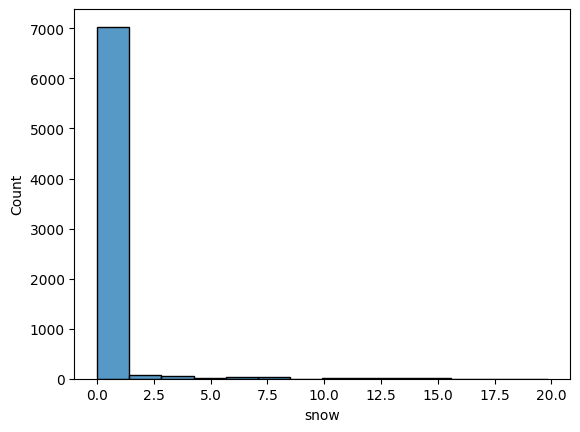

In [1447]:
sns.histplot(data = df_all, x = 'snow')
plt.show()

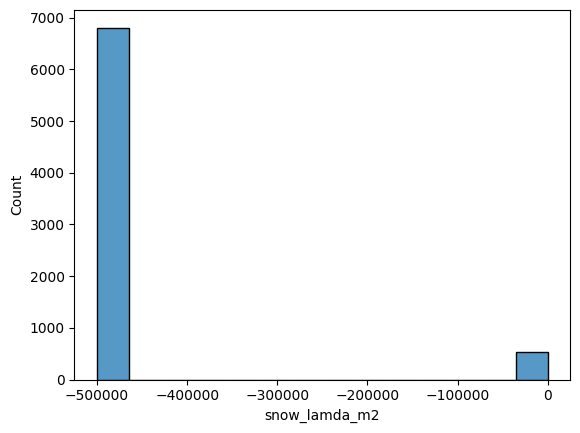

In [1448]:
sns.histplot(data = df_all, x = 'snow_lamda_m2')
plt.show()

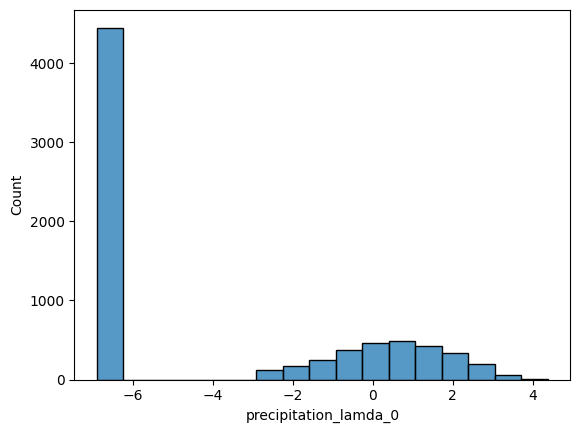

In [1449]:
sns.histplot(data = df_all, x = 'precipitation_lamda_0')
plt.show()

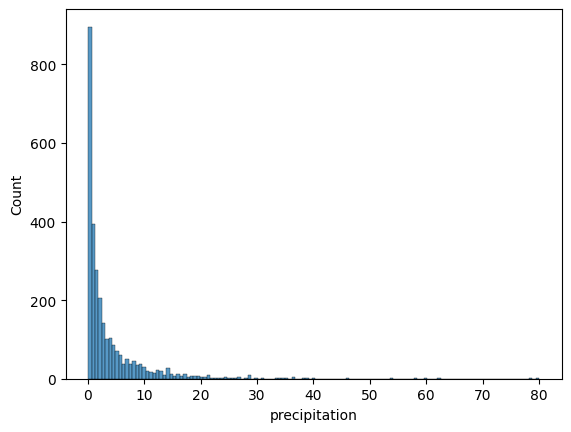

In [1450]:
sns.histplot(data = df_all[df_all['precipitation']!=0], x = 'precipitation')
plt.show()

In [1451]:
# show categorical columns
df_all.select_dtypes(include = 'object').columns

Index(['city', 'holiday_name', 'id', 'warehouse'], dtype='object')

In [1452]:
# print columns that have only one unique value
for col in df_all.columns:
  if len(df_all[col].unique()) == 1:
    print(col)

warehouse_limited


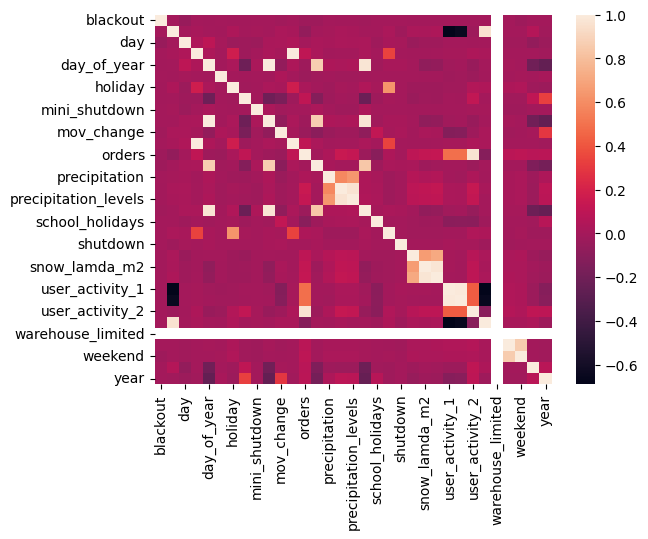

In [1453]:
df_corr = df_all.select_dtypes(include = 'number').corr()
sns.heatmap(data = df_corr)
plt.show()

In [1454]:
df_corr[df_corr > 0.7]

,blackout,city_code,day,day_importance,day_of_year,frankfurt_shutdown,holiday,is_leap_year,mini_shutdown,month,...,snow_levels,user_activity_1,user_activity_1_levels,user_activity_2,warehouse_code,warehouse_limited,weekday,weekend,winter_school_holidays,year
blackout,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city_code,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.955284,NaN,NaN,NaN,NaN,NaN
day,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_importance,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_year,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.996787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
frankfurt_shutdown,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_leap_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mini_shutdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,NaN,NaN,0.996787,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observations**
- precipitation vs orders (transform: boxcox)
- snow vs orders (transform: boxcox)
- user_activity_1 vs orders (transform: boxcox - weird function)
- months 9-12 might need to be bucketed

## Outputs

In [1455]:
# save all data
filepath1 = data_folder + 'all_train.csv'
df_all.to_csv(path_or_buf = filepath1, header = True, index = False)